# MIMICScn_hist
- Reads in MIMICS results and checks for change in soil and veg C pool & fluxes
- Migrated to using CLM5 GSWP3 forcing, which has reduced biases in mid- and high lats
- Data are here /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod4_dens1.0_KO6_GSWP3/OUTPUT_CN/SPIN
- Current parameterization removed density dependent turnover from Kyker-Snowman et al. 2020
- also increases boreal Nfix from CASA, not sure if this really has much influence

#### --- increased MIMICS leaching & modifiend density dependend parameterizaiton ---
- **Switched to updated CLM5-GSWP3 inputs (created with ctsm_dev110 tag)**
- `MIMICS_mod3_borealNfix_GSWP3`, increase Nfix in boreal systems NOT plotted here, **maybe revert?**
- `MIMICS_mod4_dens1.0_KO6_GSWP3`, KO = 6, turnover * desorbtion as in `MIMICS_desorb2`
- **`MIMICS_mod4_dens1.0_KO6_oldFIX_GSWP3`***`
  - as above, but reverts the boreal Nfix change for all simulations
  - This seems like the **best** run & most similar to previously published C-only simulations
- `MIMICS_mod4_dens1.0_KO6_Conly`, C-only of above
- `CASACNP_mod4_GSWP3`
- `CASACNP_mod4_Conly`

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import utils
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

# some resources for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

print('xarray version ' + xr.__version__)
%matplotlib inline

0.16.1


In [6]:
#import pandas.util.testing as tm
path  = '/project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/'
outCN = '/OUTPUT_CN/HIST/'
outC  = '/OUTPUT_C/HIST/'
year  = [1901,2014] # for first and last year of simulations 
# CASA CN
CASsimCN = 'CASACNP_mod4_GSWP3'
pathCAScn = [path+CASsimCN+outCN+'casaclm_pool_flux_'+str(i)+'_daily.nc' for i in year] 
pathCAScnANN = path+CASsimCN+outCN+'ann_casaclm_pool_flux_1901_2014.nc' 

# CASA C only
CASsimC = 'CASACNP_mod4_Conly'
pathCASc = [path+CASsimC+outC+'casaclm_pool_flux_'+str(i)+'_daily.nc' for i in year] 
pathCAScANN = path+CASsimC+outC+'ann_casaclm_pool_flux_1901_2014.nc' 


# MIMICS CN
MIMsimCN = 'MIMICS_mod4_dens1.0_KO6_micCN_oldFIX_GSWP3'
pathMIMcn = [path+MIMsimCN+outCN+'mimics_pool_flux_'+str(i)+'_daily.nc' for i in year]  
pathMIMcn2= [path+MIMsimCN+outCN+'casaclm_pool_flux_'+str(i)+'_daily.nc' for i in year] 
pathMIMcnANN = path+MIMsimCN+outCN+'ann_mimics_pool_flux_1901_2014.nc'  
pathMIMcn2ANN= path+MIMsimCN+outCN+'ann_casaclm_pool_flux_1901_2014.nc'  
print(pathMIMcn)
print(pathMIMcnANN)
print(pathMIMcn2ANN)

# MIMICS C only
MIMsimC  = 'MIMICS_mod4_dens1.0_KO6_Conly'
pathMIMc = [path+MIMsimC+outC+'mimics_pool_flux_'+str(i)+'_daily.nc'  for i in year]  
pathMIMc2= [path+MIMsimC+outC+'casaclm_pool_flux_'+str(i)+'_daily.nc' for i in year]   
pathMIMcANN = path+MIMsimC+outC+'ann_mimics_pool_flux_1901_2014.nc'  
pathMIMc2ANN= path+MIMsimC+outC+'ann_casaclm_pool_flux_1901_2014.nc'  

['/project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod4_dens1.0_KO6_micCN_oldFIX_GSWP3/OUTPUT_CN/HIST/mimics_pool_flux_1901_daily.nc', '/project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod4_dens1.0_KO6_micCN_oldFIX_GSWP3/OUTPUT_CN/HIST/mimics_pool_flux_2014_daily.nc']
/project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod4_dens1.0_KO6_micCN_oldFIX_GSWP3/OUTPUT_CN/HIST/ann_mimics_pool_flux_1901_2014.nc
/project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod4_dens1.0_KO6_micCN_oldFIX_GSWP3/OUTPUT_CN/HIST/ann_casaclm_pool_flux_1901_2014.nc


#### Open datasets and combine MIMICS output into one file

In [3]:
# CASAcn
CAScnANN  = xr.open_mfdataset(pathCAScnANN, decode_times=True, combine='by_coords')

#CASAc only
CAScANN  = xr.open_mfdataset(pathCAScANN, decode_times=True, combine='by_coords')

# MIMICScn
MIMcn1ANN = xr.open_mfdataset(pathMIMcnANN, decode_times=True, combine='by_coords')
MIMcn2ANN = xr.open_mfdataset(pathMIMcn2ANN, decode_times=True, combine='by_coords')
MIMcnANN = xr.combine_by_coords([MIMcn1ANN, MIMcn2ANN], compat='override',
                                data_vars='all',combine_attrs='override')

# MIMICSc only
MIMc1ANN = xr.open_mfdataset(pathMIMcANN, decode_times=True, combine='by_coords')
MIMc2ANN = xr.open_mfdataset(pathMIMc2ANN, decode_times=True, combine='by_coords')
MIMcANN = xr.combine_by_coords([MIMc1ANN, MIMc2ANN], compat='override',
                               data_vars='all',combine_attrs='override')

print('-- read in annual dataset -- ')

-- read in annual dataset -- 


In [4]:
MIMcn1 = [xr.open_mfdataset(p, decode_times=True, combine='by_coords') for p in pathMIMcn]
MIMcn2 = [xr.open_mfdataset(p, decode_times=True, combine='by_coords') for p in pathMIMcn2]
MIMc1 = [xr.open_mfdataset(p, decode_times=True, combine='by_coords') for p in pathMIMc]
MIMc2 = [xr.open_mfdataset(p, decode_times=True, combine='by_coords') for p in pathMIMc2]
CAScn = [xr.open_mfdataset(p, decode_times=True, combine='by_coords') for p in pathCAScn]
CASc = [xr.open_mfdataset(p, decode_times=True, combine='by_coords') for p in pathCASc]

yeardim = xr.DataArray(year, dims='year', name='year') # or can use np.arange
yeardim

def reshapeDataset(ds):
    # convert decimal year to day of year
    ds[0]['time'] = np.round(((ds[0]['time'] - 1901)*365), 0)
    ds[1]['time'] = ds[0]['time'] 
    ds = xr.concat(ds, dim=yeardim)
    ds = ds.rename({'time':'DOY'})
    return(ds)
    
MIMcn1 = reshapeDataset(MIMcn1)
MIMcn2 = reshapeDataset(MIMcn2)
MIMc1 = reshapeDataset(MIMc1)
MIMc2 = reshapeDataset(MIMc2)
CAScn = reshapeDataset(CAScn)
CASc = reshapeDataset(CASc)

MIMcn = xr.combine_by_coords([MIMcn1, MIMcn2], compat='override',data_vars='all',combine_attrs='override')
MIMc = xr.combine_by_coords([MIMc1, MIMc2], compat='override',data_vars='all',combine_attrs='override')
print('-- read in daily dataset -- ')

-- read in daily dataset -- 


In [5]:
MIMcn

<xarray.Dataset>
Dimensions:              (DOY: 365, lat: 96, lon: 144, year: 2)
Coordinates:
  * lon                  (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * lat                  (lat) float32 -90.0 -88.10526 ... 88.10526 90.0
  * DOY                  (DOY) float32 1.0 2.0 3.0 4.0 ... 363.0 364.0 365.0
  * year                 (year) int64 1901 2014
Data variables:
    day                  (year, DOY) int32 1 2 3 4 5 6 ... 361 362 363 364 365
    IGBP_PFT             (year, lat, lon) float64 nan nan nan ... nan nan nan
    landarea             (year, lat, lon) float32 nan nan nan ... nan nan nan
    cellMissing          (year, lat, lon) int32 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    cellid               (year, lat, lon) int32 1 97 193 ... 13632 13728 13824
    cLITm                (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    cLITs                (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    cMICr                (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    cMICk                (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    cSOMa                (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    cSOMc                (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    cSOMp                (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    cHresp               (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    cSOMpIn              (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    cLitInput_metb       (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    cLitInput_struc      (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    cOverflow_r          (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    cOverflow_k          (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    nLITm                (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    nLITs                (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    nMICr                (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    nMICk                (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    nSOMa                (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    nSOMc                (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    nSOMp                (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    DIN                  (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    nLitInput_metb       (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    nLitInput_struc      (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    thetaLiq             (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    thetaFrzn            (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    fW                   (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    cresp                (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    cnpp                 (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    cgpp                 (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    cleaf                (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    nleaf                (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    cwood                (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    nwood                (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    cfroot               (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    nfroot               (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    clitmetb             (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    nlitmetb             (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    clitstr              (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    nlitstr              (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    clitcwd              (year, DOY, lat, lon) float32 nan nan nan ... nan nan
    nlitcwd              (year, DOY, lat, lon) float32 nan na

#### Sum soil C & N pools

In [7]:
# Single annual cycle:
CAScn = utils.sum_pools(CAScn,'cas',CN='True')
CASc  = utils.sum_pools(CASc, 'cas',CN='False')
MIMcn = utils.sum_pools(MIMcn,'mim',CN='True')
MIMc  = utils.sum_pools(MIMc, 'mim',CN='False')

# Full transient time series (annual mean) 
CAScnANN = utils.sum_pools(CAScnANN,'cas',CN='True')
CAScANN  = utils.sum_pools(CAScANN, 'cas',CN='False')
MIMcnANN = utils.sum_pools(MIMcnANN,'mim',CN='True')
MIMcANN  = utils.sum_pools(MIMcANN, 'mim',CN='False')

# get correct respiration flux onto MIMICS output
MIMcn['cresp']   = MIMcn['cHresp']
MIMcnANN['cresp']= MIMcnANN['cHresp']
MIMc['cresp']    = MIMc['cHresp']
MIMcANN['cresp'] = MIMcANN['cHresp']

### zonal means

In [8]:
var  =  ['cnpp', 'cgpp','cTOT']
varLong  =  ['npp', 'gpp','total soil C']

#Mask out low productivity grids
minGPP = 10/365 # gpp given in gC/m2/d
MIMcnANN = MIMcnANN.where(MIMcnANN.cgpp>minGPP)
CAScnANN = CAScnANN.where(CAScnANN.cgpp>minGPP)
CAScANN = CAScANN.where(CAScANN.cgpp>minGPP)
MIMcANN = MIMcANN.where(MIMcANN.cgpp>minGPP)

# unweighted zonal means
zon_meanCNmim = MIMcnANN.mean(dim='lon') 
zon_meanCNcas = CAScnANN.mean(dim='lon')
zon_meanCcas = CAScANN.mean(dim='lon') 
zon_meanCmim = MIMcANN.mean(dim='lon') 

# Read observations:
- Microbial C:N, Xu et al. 2013  https://doi-org.cuucar.idm.oclc.org/10.1111/geb.12029, avail @ https://doi.org/10.3334/ORNLDAAC/1264
- Soil C:N_GSDE, Shangguan et al. 2014, doi:10.1002/2013MS000293, avail @ http://globalchange.bnu.edu.cn/research/soilwd.jsp, 
- Soil C HWSD and NCSCD
- HR Hashimoto et al Biogeosciences 12: 4121-4132. doi:10.5194/bg-12-4121-2015, downloaded from http://cse.ffpri.affrc.go.jp/shojih/data/index.html

In [9]:
obsIn = "/project/tss/wwieder/soilCN/global_run/"

xuMic = obsIn+'GLOBAL_MICROBIAL_BIOMASS_C_N_P_1264/data/Global_Soil_Microbial_BiomassCN.nc'
dsXu = xr.open_mfdataset(xuMic, decode_times=True,combine='by_coords')
#dsXu.CN100cm.plot(robust=True);

GSDE = obsIn+'GSDE/'
GSDEoc = xr.open_mfdataset(GSDE+'OC5min.nc', decode_times=True,combine='by_coords')
GSDEtn = xr.open_mfdataset(GSDE+'TN5min.nc', decode_times=True,combine='by_coords')
GSDEoc['CN'] = GSDEoc.OC / GSDEtn.TN.where(GSDEtn.TN>0)
GSDEoc['CNmean'] = GSDEoc.CN.where(GSDEoc.depth<=100).mean(dim='depth')

HWSD = obsIn+'input_data/Soil_obs.nc'
dsOBS = xr.open_mfdataset(HWSD, decode_times=True,combine='by_coords')

NCSCD = obsIn+'input_data/NCSCD_Circumarctic_100cmSOCC_025deg.nc'
dsNCSCD = xr.open_mfdataset(NCSCD, decode_times=True,combine='by_coords')

dsHR = xr.open_mfdataset((obsIn+'RH_yr_Hashimoto2015.nc'), decode_times=False,combine='by_coords' )
#dims = time, lev, lat, lon gC/m2/y

dsOBS['HWSD_SOCall'] = dsOBS.HWSD_SOC.sum(dim='nlevsoi').where(dsOBS.HWSD_SOC.isel(nlevsoi=0)>0)
dsOBS['HWSD_SOCall'].attrs = dsOBS.HWSD_SOC.attrs
#dsOBS.HWSD_SOCall.plot();
zon_meanOBS = dsOBS.mean(dim='lon') * 1000 #gC/m2
#dsNCSCD.NCSCD_SOC

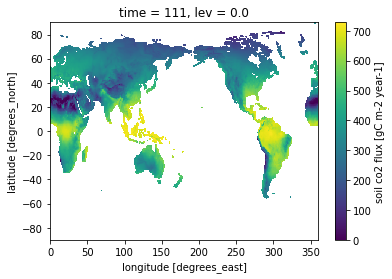

In [10]:
dsHR.co2.isel(time=-1,lev=0).plot();

### Plot zonal means for models and observations

/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


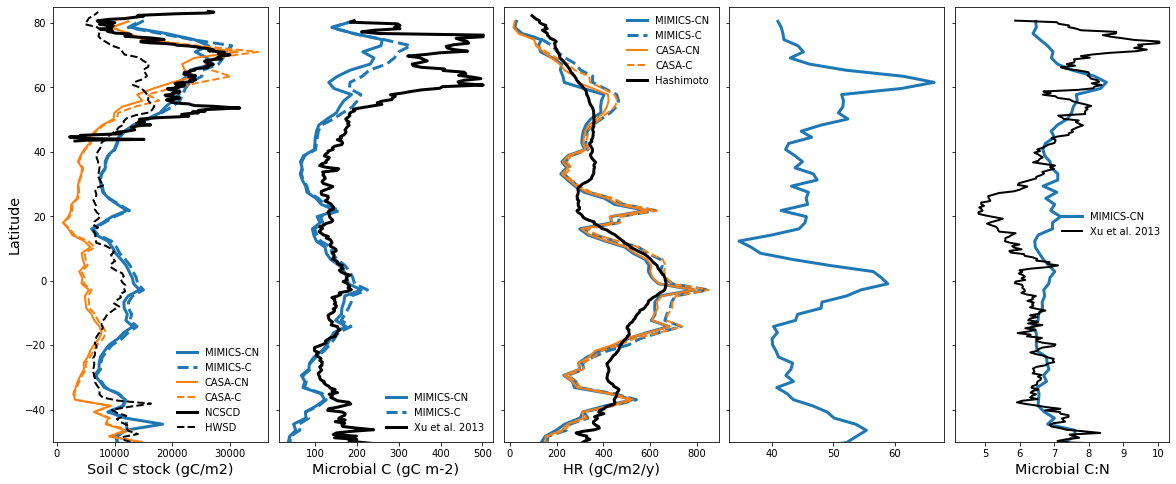

In [11]:
tPlot = -1
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=True, figsize=[20,8])
# Remove space between axes
fig.subplots_adjust(hspace=0, wspace=0.05)
color = ['tab:blue','tab:orange'] # for MIM, CAS
linestyle= ['-', '--']            # for CN,  Conly

# SOC
labels = ['MIMICS-CN','MIMICS-C','CASA-CN','CASA-C','NCSCD','HWSD']
ax1.plot(zon_meanCNmim.get('cTOT').isel(time=tPlot), zon_meanCNmim.lat,lw=3,color=color[0],linestyle=linestyle[0])
ax1.plot(zon_meanCmim.get('cTOT').isel(time=tPlot),  zon_meanCmim.lat, lw=3,color=color[0],linestyle=linestyle[1])
ax1.plot(zon_meanCNcas.get('cTOT').isel(time=tPlot), zon_meanCNcas.lat,lw=2,color=color[1],linestyle=linestyle[0])
ax1.plot(zon_meanCcas.get('cTOT').isel(time=tPlot), zon_meanCcas.lat,  lw=2,color=color[1],linestyle=linestyle[1])
ax1.plot((dsNCSCD.NCSCD_SOC.mean(dim='lon')*1e2), dsNCSCD.lat,lw=3, color='k') #convert kgC to gC/m2
ax1.plot(zon_meanOBS.get('HWSD_SOCall'), zon_meanOBS.lat,lw=2, color='k',linestyle='--')
ax1.set_xlabel('Soil C stock (gC/m2)', fontsize='x-large')
ax1.set_ylabel('Latitude', fontsize='x-large');
ax1.legend(labels=labels, frameon = False, fontsize='medium',loc=4)
ax1.set_ylim(-50, 85)

# MICc
v = 'cMICtot' # 'cnTOT' 'nMineral' 'cSOMc' 'MICrK' 'cnMIC' 'relMIC' 'specRESP'
ax2.plot(zon_meanCNmim.get(v).isel(time=tPlot), zon_meanCNmim.lat,lw=3,color=color[0],linestyle=linestyle[0])
ax2.plot(zon_meanCmim.get(v).isel(time=tPlot), zon_meanCmim.lat,lw=3,color=color[0],linestyle=linestyle[1])
ax2.plot(dsXu.SMC100cm.mean(dim='lon'), dsXu.lat,lw=3, color='k')
ax2.set_xlabel('Microbial C'+' ('+MIMcnANN.get(v).attrs['units']+')', fontsize='x-large');
labels = ['MIMICS-CN','MIMICS-C','Xu et al. 2013']
ax2.legend(labels=labels, frameon = False, fontsize='medium',loc=4)

# HR
labels = ['MIMICS-CN','MIMICS-C','CASA-CN','CASA-C','Hashimoto']
ax3.plot(zon_meanCNmim.get('cresp').isel(time=tPlot)*365, zon_meanCNmim.lat, lw=3,color=color[0],linestyle=linestyle[0])
ax3.plot(zon_meanCmim.get('cresp').isel(time=tPlot)*365,  zon_meanCmim.lat,  lw=3,color=color[0],linestyle=linestyle[1])
ax3.plot(zon_meanCNcas.get('cresp').isel(time=tPlot)*365, zon_meanCNcas.lat, lw=2,color=color[1],linestyle=linestyle[0])
ax3.plot(zon_meanCcas.get('cresp').isel(time=tPlot)*365, zon_meanCcas.lat, lw=2,color=color[1],linestyle=linestyle[1])
ax3.plot(dsHR.co2.isel(time=-1,lev=0).mean(dim='lon'), dsHR.lat,lw=3, color='k')
ax3.set_xlabel('HR (gC/m2/y)', fontsize='x-large')
ax3.legend(labels=labels, frameon = False, fontsize='medium',loc=1)

# Soil C:N
labels = ['MIMICS-CN','CASA-CN','GSDE']
v ='cnLIT' #'nMineral' 'cSOMc' 'MICrK' 'cnMIC' 'relMIC' 'specRESP'
ax4.plot(zon_meanCNmim.get(v).isel(time=tPlot), zon_meanCNmim.lat,lw=3,color=color[0],linestyle=linestyle[0])
#ax4.plot(zon_meanCNcas.get(v).isel(time=tPlot), zon_meanCmim.lat,lw=3,color=color[1],linestyle=linestyle[0])
#ax4.plot(GSDEoc['CNmean'].mean(dim='lon'), GSDEoc.lat,lw=2, color='k')
#ax4.set_xlabel('Total SOM C:N', fontsize='x-large');
#ax4.legend(labels=labels, frameon = False, fontsize='medium',loc=0)

# MIC C:N
v5 = 'cnMIC' # 'cnLIT',cnTOT' 'nMineral' 'cSOMc' 'MICrK' 'cnMIC' 'relMIC' 'specRESP'
ax5.plot(zon_meanCNmim.get(v5).isel(time=tPlot), zon_meanCNmim.lat, lw=3,color=color[0],linestyle=linestyle[0])
#ax5.plot(zon_meanCNcas.get(v5).isel(time=tPlot), zon_meanCmim.lat,  lw=3,color=color[1],linestyle=linestyle[0])
ax5.plot(dsXu.CN100cm.mean(dim='lon'), dsXu.lat,lw=2, color='k')
ax5.set_xlabel('Microbial C:N', fontsize='x-large');
labels = ['MIMICS-CN','Xu et al. 2013']
ax5.legend(labels=labels, frameon = False, fontsize='medium',loc=0);


**Figure X.** Zonal mean plots for MIMICS and CASA simulations (blue and orange lines, respectively) 
with coupled CN biogeochemistry and C-only configuration (solid and dashed lines, respectively) and relevent observations.
Panels show NPP, soil C stocks, soil C:N, microbial biomass pools, and microbial C:N ratios.
- add SD of obs?

- Models show good agreement of stocks & fluxes 
- MIMICS-cn shows weak latitudal variation in soil and microbial C:N. CASA captures is because it uses a pft defined soil C:N
- Should we we try and do a better job doing this, with FI~fMET or temperature?
- What's the C:N of chemically protected C

### Look at changes over historical period

In [12]:
def globalSum ( varIn, area=MIMcnANN.landarea.isel(time=0) *1e6, timeC=1, conversion=1e-15, units=None, pt=False):
    "Global weighted sum of fluxes & states"
    temp = varIn * area 
    temp = temp.sum(dim=('lat','lon')) * conversion * timeC
    if pt==True:
        print(varIn.attrs['long_name']+' '+str(np.round(temp.values,1))+' Pg C')
    return(temp)

d2y = 365
print('MIMICS cn')
globalSum(MIMcnANN['cgpp'].isel(time=0),timeC=d2y, pt=True)
globalSum(MIMcnANN['cnpp'].isel(time=0),timeC=d2y, pt=True)
globalSum(MIMcnANN['cTOT'].isel(time=0), pt=True);
print(MIMcnANN)

MIMICS cn
gross primary production 105.1 Pg C
net primary production 36.3 Pg C
sum of all pools 1454.7 Pg C
<xarray.Dataset>
Dimensions:              (lat: 96, lon: 144, time: 114)
Coordinates:
  * lon                  (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * lat                  (lat) float32 -90.0 -88.10526 ... 88.10526 90.0
  * time                 (time) float32 1901.5013 1902.5013 ... 2014.5013
Data variables:
    day                  (time, lat, lon) float64 nan nan nan ... nan nan nan
    IGBP_PFT             (lat, lon, time) float64 nan nan nan ... nan nan nan
    landarea             (lat, lon, time) float32 nan nan nan ... nan nan nan
    cellMissing          (lat, lon, time) float64 nan nan nan ... nan nan nan
    cellid               (lat, lon, time) float64 nan nan nan ... nan nan nan
    cLITm                (time, lat, lon) float32 nan nan nan ... nan nan nan
    cLITs                (time, lat, lon) float32 nan nan nan ... nan nan nan
    cMICr           

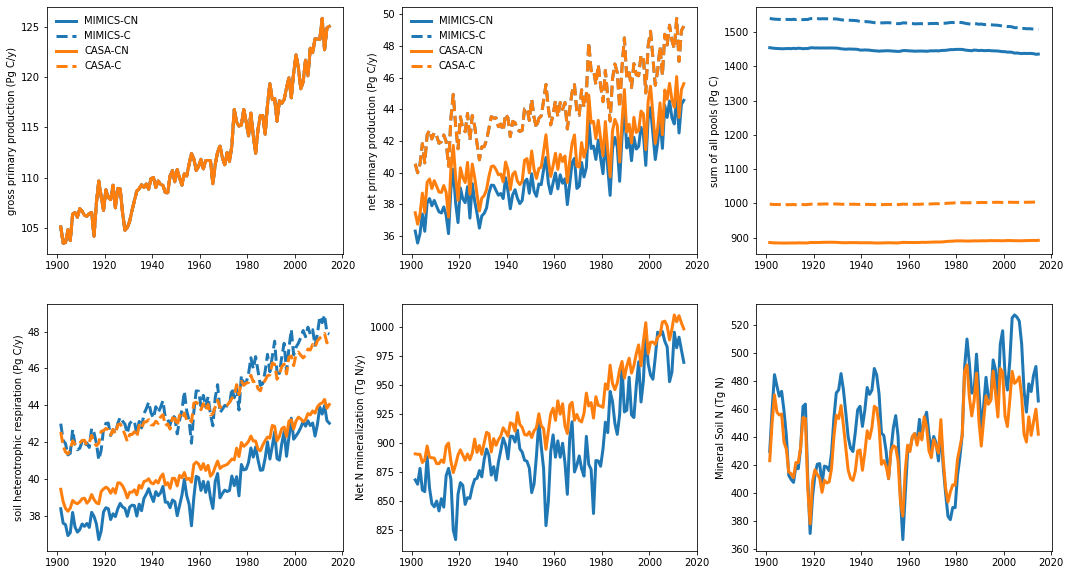

In [13]:
model = ['MIMICS-CN','MIMICS-C','CASA-CN','CASA-C']
var = ['cgpp','cnpp','cTOT',
       'cresp','nNetMineralization','nMineral']
nvar  = len(var)
timeC = [365,365,1,365,365,1]
conversion = [1e-15,1e-15,1e-15,1e-15,1e-12,1e-12]
units = ['(Pg C/y)','(Pg C/y)','(Pg C)',
         '(Pg C/y)','(Tg N/y)','(Tg N)']

plt.figure(figsize=[18,10]);
for i in range(nvar):
    plt.subplot(2, (nvar/2), (1+i))
    plt.ylabel(MIMcnANN[var[i]].attrs['long_name']+' '+units[i])
    plt.plot(MIMcnANN.time, globalSum(MIMcnANN[var[i]],timeC=timeC[i],conversion=conversion[i]), 
             lw=3,color=color[0],linestyle=linestyle[0])
    if i<=3: 
        plt.plot(MIMcnANN.time, globalSum(MIMcANN[var[i]],timeC=timeC[i],conversion= conversion[i]), 
             lw=3,color=color[0],linestyle=linestyle[1])

    plt.plot(CAScnANN.time, globalSum(CAScnANN[var[i]],timeC=timeC[i],conversion=conversion[i]), 
             lw=3,color=color[1],linestyle=linestyle[0])
    if i<=3: 
        plt.plot(MIMcnANN.time, globalSum(CAScANN[var[i]],timeC=timeC[i],conversion= conversion[i]), 
             lw=3,color=color[1],linestyle=linestyle[1])
        
    if i<2:
        plt.legend(labels=model, frameon = False, fontsize='medium')

**Figure X** trends in ecosystem C & N fluxes and pools over the historical period simulated by MIMICS and CASA (blue and orange lines, respectively), with coupled C-N biogeochemistry and C-only configuration (solid and dashed lines, respectively).
- **MIMICS seems to show evidence of priming in second half of simulation, increasing HR and Nmin rates faster than CASA?**

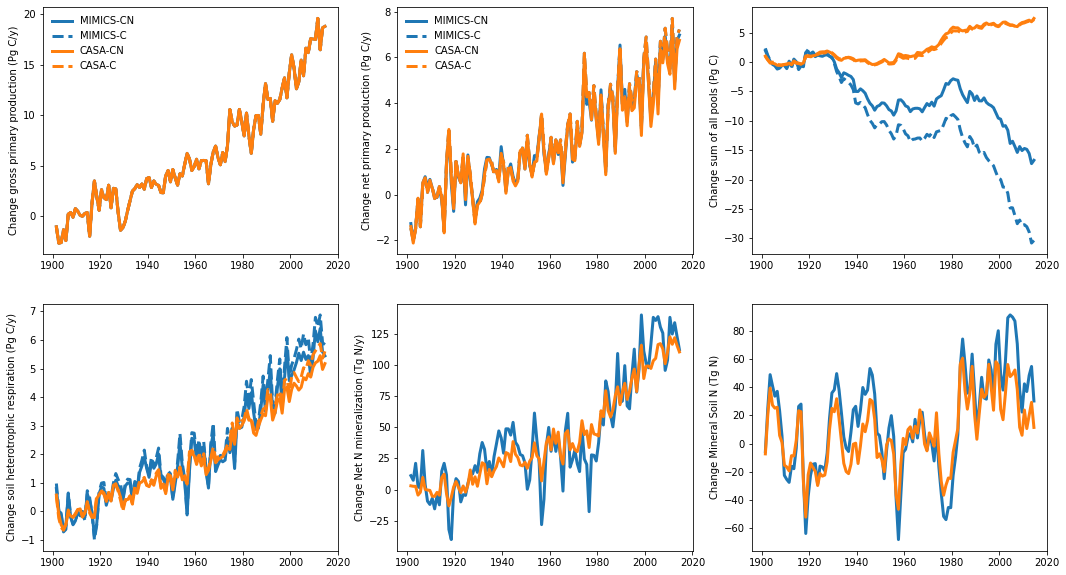

In [14]:
plt.figure(figsize=[18,10]);
for i in range(nvar):
    plt.subplot(2, (nvar/2), (1+i))
    daMIMcn = globalSum(MIMcnANN[var[i]],timeC=timeC[i],conversion=conversion[i])
    daCAScn = globalSum(CAScnANN[var[i]],timeC=timeC[i],conversion=conversion[i])
    plt.ylabel('Change '+MIMcnANN[var[i]].attrs['long_name']+' '+units[i])
    plt.plot(daMIMcn.time, (daMIMcn-daMIMcn.isel(time=slice(0,20)).mean()),
             lw=3,color=color[0],linestyle=linestyle[0]) 
    if i<=3: 
        daMIMc = globalSum(MIMcANN[var[i]],timeC=timeC[i],conversion=conversion[i])
        plt.plot(daMIMcn.time, (daMIMc-daMIMc.isel(time=slice(0,20)).mean()), 
                 lw=3,color=color[0],linestyle=linestyle[1]) 

    plt.plot(daMIMcn.time,(daCAScn-daCAScn.isel(time=slice(0,20)).mean()), 
             lw=3,color=color[1],linestyle=linestyle[0]) 
    if i<=3: 
        daCASc = globalSum(CAScANN[var[i]],timeC=timeC[i],conversion=conversion[i])
        plt.plot(daMIMcn.time, (daCASc-daCASc.isel(time=slice(0,20)).mean()), 
                 lw=3,color=color[1],linestyle=linestyle[1])         
    if i<2:
        plt.legend(labels=model, frameon = False, fontsize='medium')

**Figure X** Changes in ecosystem C & N fluxes and pools, relative to initial conditions, over the historical period 
simulated by MIMICS and CASA (blue and orange lines, respectively), with coupled C-N biogeochemistry and C-only 
configuration (solid and dashed lines, respectively).
- **MIMICS seems to show evidence of priming in second half of simulation, increasing HR and Nmin rates faster than CASA?**

### Plot maps of where fluxes are changing

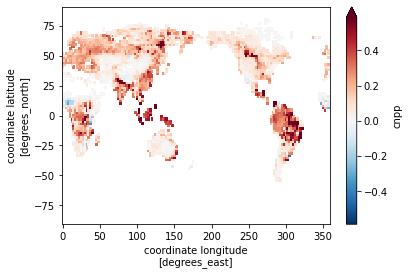

In [15]:
var='cnpp'
(MIMcnANN[var].isel(time=slice(-10,None)).mean(dim='time')-
 MIMcnANN[var].isel(time=slice(  0,10  )).mean(dim='time')).plot(robust=True);

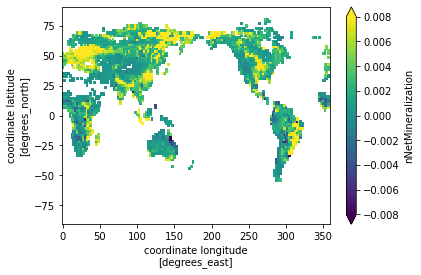

In [16]:
var = ['cresp','nNetMineralization']
(MIMcnANN[var[1]].isel(time=slice(-10,None)).mean(dim='time')-
 MIMcnANN[var[1]].isel(time=slice(  0,10  )).mean(dim='time')).plot(vmin=-8e-3, vmax=8e-3);

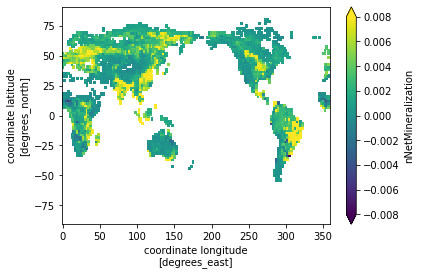

In [17]:
(CAScnANN[var[1]].isel(time=slice(-10,None)).mean(dim='time')-
 CAScnANN[var[1]].isel(time=slice(  0,10  )).mean(dim='time')).plot(vmin=-8e-3, vmax=8e-3);

In [18]:
#changes in mineralization over time in both models
var = ['cnpp','cresp','nNetMineralization']
dMIM = MIMcnANN[var].copy('deep')
dCAS = CAScnANN[var].copy('deep')
for i in range(len(var)):
    dMIM[var[i]] = (MIMcnANN[var[i]]-MIMcnANN[var[i]].isel(time=slice(0,10)).mean(dim='time')).mean(dim='lon')
    dCAS[var[i]] = (CAScnANN[var[i]]-CAScnANN[var[i]].isel(time=slice(0,10)).mean(dim='time')).mean(dim='lon')

model = xr.DataArray(['MIMICS-cn','CASA-cn'], dims='model', name='model') # or can use np.arange
t = xr.concat([dMIM,dCAS],dim=model)
##t['lat'] = t.lat.where(t.lat> -50)
#t

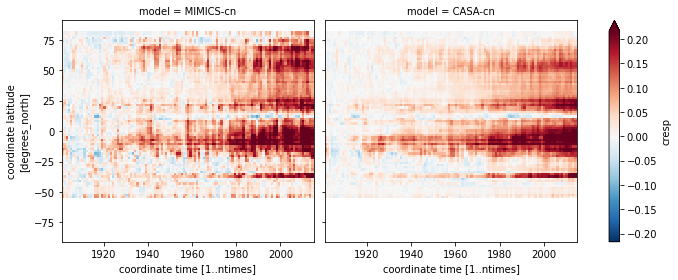

In [19]:
simple = t[var[1]].plot(x='time', y='lat',col='model',col_wrap=2, figsize=[10,4],robust=True);

**Figure X.** Zonal mean changes in N mineralization rates simulated by MIMICS-cn & CASA-cn

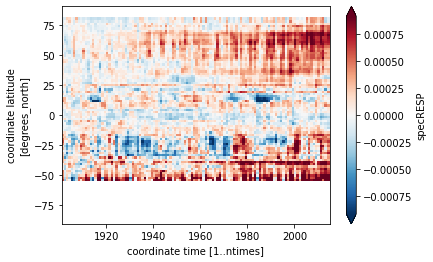

In [20]:
# look a some MIM specific results
var = ['specRESP','cMICtot','MICrK','cnMIC']
(MIMcnANN[var[0]]-MIMcnANN[var[0]].isel(time=slice(0,10)).mean(dim='time')).mean(dim='lon').plot(x='time',y='lat',robust=True);
#MIMcnANN

### Look at environmental controls over soil C:N in MIMICS

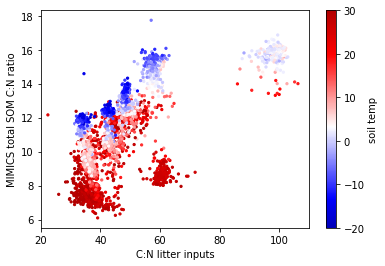

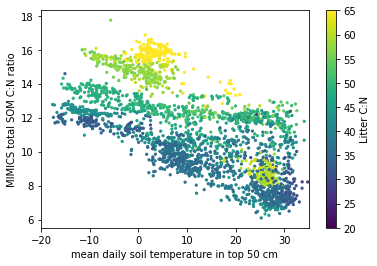

In [21]:
ds_1 = MIMcnANN.isel(time=0)
ds_1['cnLIT'] = (ds_1.cLitInput_metb + ds_1.cLitInput_struc) / (ds_1.nLitInput_metb + ds_1.nLitInput_struc)
ds_1['cnLIT'].attrs['long_name'] = 'C:N litter inputs'

color_by = ds_1.tsoilC
label = 'soil temp'  # Need to rename if 'color_by' is changed

fig, ax = plt.subplots()
s = ax.scatter(ds_1['cnLIT'], ds_1['cnTOT'],
               c=color_by,
               s=5,
               marker='o',                   # Plot circles
              # alpha = 0.2,
               cmap = utils.truncate_colormap(cmapIn='seismic', minval=.15, maxval=.9),#plt.cm.seismic, # Color pallete coolwarm
               vmin = -20,            # Min value
               vmax = 30)             # Max value

# Mappable 'maps' the values of s to an array of RGB colors defined by a color palette
cbar = plt.colorbar(mappable = s, ax = ax)   
cbar.set_label(label)
plt.xlabel(ds_1['cnLIT'].attrs['long_name'])
plt.ylabel(ds_1['cnTOT'].attrs['long_name'])
ax.set_xlim(20, 110)
plt.show();

color_by = ds_1['cnLIT'] 
label = 'Litter C:N'     
#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6), constrained_layout=True)
fig, ax = plt.subplots()
s = ax.scatter(ds_1.tsoilC, ds_1['cnTOT'],
               c=color_by,
               s=5,
               marker='o',                   # Plot circles
              # alpha = 0.2,
               #cmap = truncate_colormap(cmapIn='seismic', minval=.15, maxval=.9),#plt.cm.seismic, # Color pallete coolwarm
               vmin = 20,            # Min value
               vmax = 65)             # Max value

# Mappable 'maps' the values of s to an array of RGB colors defined by a color palette
cbar = plt.colorbar(mappable = s, ax = ax)   
cbar.set_label(label)
plt.xlabel(ds_1['tsoilC'].attrs['long_name'])
plt.ylabel(ds_1['cnTOT'].attrs['long_name'])
ax.set_xlim(-20, 35)
plt.show();


**Figure X** Litter quality and temperature interact to control soil C:N. 

### Annual cycle of fluxes
This can be done for grid cells, or zonally

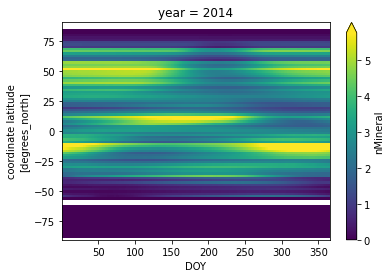

In [49]:
var = ['cMICtot','nMineral','cresp','nNetMineralization','MICrK','cnMIC','cnpp']
v = 1
MIMcn.isel(year=-1)[var[v]].mean(dim='lon').plot(x='DOY', robust=True);

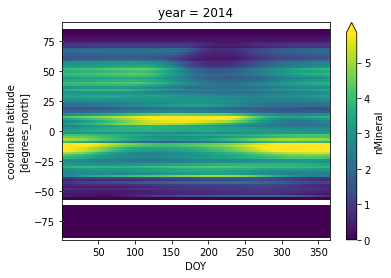

In [25]:
CAScn.isel(year=-1)[var[v]].mean(dim='lon').plot(x='DOY', robust=True);

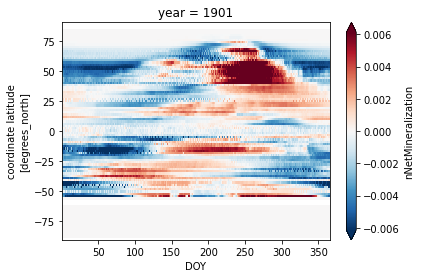

In [56]:
# Differences betweeen models (MIMICS-CASA)
v = 3
(MIMcn.isel(year=0)[var[v]] - CAScn.isel(year=0)[var[v]]).mean(dim='lon').plot(x='DOY', robust=True);

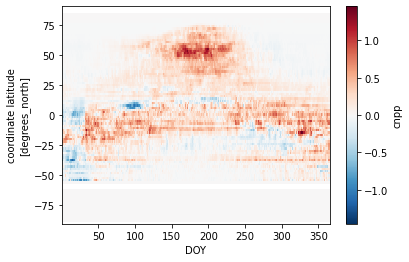

In [51]:
v = 6
(MIMcn.isel(year=1)[var[v]] - MIMcn.isel(year=0)[var[v]]).mean(dim='lon').plot(
    x='DOY', cmap='RdBu_r');#, vmax=1e-2,vmin=-1e-2);

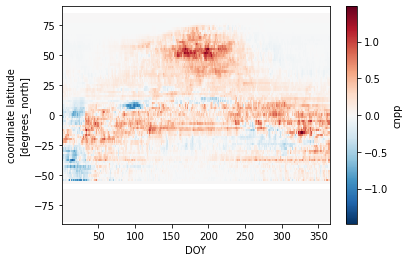

In [53]:
(CAScn.isel(year=1)[var[v]] - CAScn.isel(year=0)[var[v]]).mean(dim='lon').plot(
    x='DOY', cmap='RdBu_r');#, vmax=1e-2,vmin=-1e-2) ;

In [186]:
plt.plt(MIMcnANN.cnLIT.isel(time=-1).plot(robust=True).mean(dim='lon'), MIMcnANN.lat,lw=3, color='k')

AttributeError: module 'matplotlib.pyplot' has no attribute 'plt'

In [197]:
MIMcnANN

<xarray.Dataset>
Dimensions:              (lat: 96, lon: 144, time: 114)
Coordinates:
  * lon                  (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * lat                  (lat) float32 -90.0 -88.10526 ... 88.10526 90.0
  * time                 (time) float32 1901.5013 1902.5013 ... 2014.5013
Data variables:
    day                  (time, lat, lon) float64 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    IGBP_PFT             (lat, lon, time) float64 dask.array<chunksize=(96, 144, 114), meta=np.ndarray>
    landarea             (lat, lon, time) float32 dask.array<chunksize=(96, 144, 114), meta=np.ndarray>
    cellMissing          (lat, lon, time) float64 dask.array<chunksize=(96, 144, 114), meta=np.ndarray>
    cellid               (lat, lon, time) float64 dask.array<chunksize=(96, 144, 114), meta=np.ndarray>
    cLITm                (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    cLITs                (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    cMICr                (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    cMICk                (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    cSOMa                (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    cSOMc                (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    cSOMp                (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    cHresp               (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    cSOMpIn              (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    cLitInput_metb       (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    cLitInput_struc      (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    cOverflow_r          (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    cOverflow_k          (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    nLITm                (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    nLITs                (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    nMICr                (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    nMICk                (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    nSOMa                (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    nSOMc                (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    nSOMp                (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    DIN                  (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    nLitInput_metb       (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    nLitInput_struc      (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    thetaLiq             (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    thetaFrzn            (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    fW                   (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    cresp                (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    cnpp                 (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    cgpp                 (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    cleaf                (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    nleaf                (time, la

TypeError: unsupported operand type(s) for /: 'int' and 'range'